### Semi-supervised learning
## Multi-tasking 
Data taken from https://www.kaggle.com/datasets/prathamgrover/3d-liver-segmentation?resource=download'

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import os
import sys
import glob
import itertools
from pathlib import Path
cd= Path.cwd().parent
sys.path.append(str(cd))

from func.utill import visualize_slices, DiceLoss


In [10]:

INPUT_SHAPE = (32, 32, 32) # (C, D, H, W)
NUM_CLASSES = 3  # Background, Segment 1, Segment 2
LATENT_DIM = 256
BATCH_SIZE = 4
NUM_EPOCHS = 20

# !!! CHECK THIS PATH !!!
DATA_DIR = "./Task03_Liver_rs" 
# !!! CHECK THIS PATH !!!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.3)
        )
    def forward(self, x):
        return self.conv(x)
    
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # Input: 1x32x32x32
        self.enc1 = ConvBlock(in_channels, 32) # -> 32x32x32
        self.pool1 = nn.MaxPool3d(2)           # -> 32x16x16
        
        self.enc2 = ConvBlock(32, 64)          # -> 64x16x16
        self.pool2 = nn.MaxPool3d(2)           # -> 64x8x8

        self.enc3 = ConvBlock(64, 128)         # -> 128x8x8
        self.pool3 = nn.MaxPool3d(2)           # -> 128x4x4
        
    def forward(self, x):
        s1 = self.enc1(x)
        p1 = self.pool1(s1)
        s2 = self.enc2(p1)
        p2 = self.pool2(s2)
        s3 = self.enc3(p2)
        p3 = self.pool3(s3) # p3 is 128x4x4
        return p3, s1, s2, s3

class Seg_decoder(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # b (bottleneck) is 256x4x4
        self.up_seg1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2) # -> 128x8x8
        self.dec_seg1 = ConvBlock(256, 128) # 128+128 = 256
        
        self.up_seg2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x16x16
        self.dec_seg2 = ConvBlock(128, 64) # 64+64 = 128

        self.up_seg3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x32x32
        self.dec_seg3 = ConvBlock(64, 32) # 32+32 = 64
        
        self.out_seg = nn.Conv3d(32, num_classes, kernel_size=1)
        
    def forward(self, b , s1, s2, s3):
        us1 = self.up_seg1(b) # 8x8x8
        ds1 = self.dec_seg1(torch.cat([us1, s3], dim=1)) # cat [8x8x8] w [8x8x8]
        
        us2 = self.up_seg2(ds1) # 16x16x16
        ds2 = self.dec_seg2(torch.cat([us2, s2], dim=1)) # cat [16x16x16] w[16x16x16]

        us3 = self.up_seg3(ds2) # 32x32x32
        ds3 = self.dec_seg3(torch.cat([us3, s1], dim=1)) # cat [32x32x32] w [32x32x32]
        us4 = self.out_seg(ds3) 
        return us4
    
class Recon_decoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # b (bottleneck) is 256x4x4
        self.up_recon1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2) # -> 128x8x8
        self.dec_recon1 = ConvBlock(128, 128)

        self.up_recon2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2) # -> 64x16x16
        self.dec_recon2 = ConvBlock(64, 64)

        self.up_recon3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2) # -> 32x32x32
        self.dec_recon3 = ConvBlock(32, 32)

        self.out_recon = nn.Sequential(
            nn.Conv3d(32, in_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, b):
        ur1 = self.up_recon1(b)
        dr1 = self.dec_recon1(ur1)
        ur2 = self.up_recon2(dr1)
        dr2 = self.dec_recon2(ur2)
        ur3 = self.up_recon3(dr2)
        dr3 = self.dec_recon3(ur3)
        ur4 = self.out_recon(dr3)
        return ur4

Using device: cpu


In [11]:

class MultiTaskNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3, latent_dim=512):
        super().__init__()
        
        # Commen encoder
        self.encoder = Encoder(in_channels)

        # Bottleneck 
        self.bottleneck = ConvBlock(128, 256) # -> 256x8x8x8
        
        # Feature vector for rnn input
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.to_latent_vec = nn.Linear(256, latent_dim) # -> Bx512

        # First decoder head for segmentation with skipped connect
        self.seg_decoder = Seg_decoder(num_classes=num_classes)

        # Second decoder head reconstruction without skipped
        self.recon_decoder = Recon_decoder(in_channels=in_channels)
        

    def forward(self, x):
        # commen encoder
        x, s1, s2, s3 = self.encoder(x)
        
        # bottleneck -> could be variational
        b = self.bottleneck(x) # [B, 256, 7, 7, 7]

        # Vectorize bottleneck output 
        pooled_vec = self.global_pool(b).view(b.size(0), -1) # -<Bx256
        latent_z = self.to_latent_vec(pooled_vec)            # ->Bx256

        # Segmentation decoder head with skips
        seg_output = self.seg_decoder(b, s1, s2, s3)

        # Reconstruction decoder head without skips
        recon_output = self.recon_decoder(b)
        
        return seg_output, recon_output, latent_z


# Temporal model -> could add more dimension 
class TemporalTracker(nn.Module):
    def __init__(self, input_dim, hidden_dim=1024, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True 
        )

        # predict t+1
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, z_sequence):
        # z_sequence shape -> Batch x Time_Steps x latent_dim
        lstm_out, _ = self.lstm(z_sequence)
        
        # only care about t+1
        last_step_out = lstm_out[:, -1, :] # -1 last time step +1 
        
        # fc layer for prediction
        prediction = self.fc(last_step_out)
        return prediction


In [12]:
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- THIS IS THE CORRECTED PART ---
    
# 1. Setup DataLoaders
CD = Path.cwd()
CD = CD.parent

DATA_DIR = CD / "Task03_Liver_rs"
DATA_DIR = DATA_DIR.resolve()
image_folder = os.path.join(DATA_DIR, 'imagesTr')
label_folder = os.path.join(DATA_DIR, 'labelsTr')


Using device: cpu


In [13]:
class LiverDataset(Dataset):
    """
    Made by AI
    Custom PyTorch Dataset for the 3D Liver Segmentation data.
    """
    def __init__(self, image_dir, label_dir, target_size=INPUT_SHAPE):
        print(image_dir)
        print(label_dir)
        # --- THIS IS THE CORRECTED PART (looking for .nii) ---
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "imagesTr","*.nii")))
        self.label_paths = sorted(glob.glob(os.path.join(label_dir, "labelsTr" , "*.nii")))      
        self.target_size = target_size # (D, H, W)
        
        # Ensure we have matched pairs
        assert len(self.image_paths) > 0, f"No images found in {image_dir}"
        assert len(self.label_paths) > 0, f"No labels found in {label_dir}"
        assert len(self.image_paths) == len(self.label_paths), \
            f"Found {len(self.image_paths)} images but {len(self.label_paths)} labels."
        
        print(f"Found {len(self.image_paths)} image/label pairs.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI files (nibabel handles .nii and .nii.gz the same way)
        img_nii = nib.load(self.image_paths[idx])
        lbl_nii = nib.load(self.label_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)
        lbl_tensor = torch.from_numpy(lbl_nii.get_fdata()).long().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        lbl_resized = F.interpolate(lbl_tensor.float().unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='nearest').squeeze(0).long()

        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # Squeeze the channel dim from the label
        lbl_resized = lbl_resized.squeeze(0) 

        return img_resized, lbl_resized

In [14]:
class LiverUnlabeledDataset(Dataset):
    """
    made by AI
    Custom PyTorch Dataset for 3D Liver UNLABELED images.
    Loads only images and returns them as a 1-item tuple.
    """
    def __init__(self, image_dir, target_size=INPUT_SHAPE, subfolder="imagesTr"):
        # Assumes unlabeled images are in a folder like 'imagesUnlabeledTr'
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, subfolder, "*.nii")))
        self.target_size = target_size # (D, H, W)
        
        assert len(self.image_paths) > 0, f"No unlabeled images found in {os.path.join(image_dir, subfolder)}"
        print(f"Found {len(self.image_paths)} unlabeled images.")

    def __len__(self):
        return len(self.image_paths)

    def normalize(self, data):
        # Normalize pixel values to [0, 1]
        data = data - torch.min(data)
        data = data / torch.max(data)
        return data

    def __getitem__(self, idx):
        # 1. Load NIfTI file
        img_nii = nib.load(self.image_paths[idx])
        
        # 2. Get data as numpy array and convert to tensor
        img_tensor = torch.from_numpy(img_nii.get_fdata()).float().permute(2, 1, 0).unsqueeze(0)

        # 3. Resize
        img_resized = F.interpolate(img_tensor.unsqueeze(0), 
                                    size=self.target_size, 
                                    mode='trilinear', 
                                    align_corners=False).squeeze(0)
        
        # 4. Normalize image
        img_resized = self.normalize(img_resized)

        # 5. Return as a 1-item tuple
        # This is important so the loop `(x_unlabeled)` unpacks correctly
        return (img_resized,)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


DATA_DIR = "./Task03_Liver_rs" 
# This one path points to the root directory (e.g., ./Task03_Liver_rs)
data_root_folder = Path.cwd().parent / DATA_DIR


try:
    # labeled set
    labeled_dataset = LiverDataset(image_dir=data_root_folder, label_dir=data_root_folder, target_size= INPUT_SHAPE)
    
    #DataLoader for labeled data
    labeled_loader = DataLoader(
        dataset=labeled_dataset,
        batch_size=BATCH_SIZE,

        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Labeled dataset: {e}")
    exit()

try:

    unlabeled_dataset = LiverUnlabeledDataset(
        image_dir=data_root_folder, 
        subfolder="imagesUnlabelledTr",
        target_size= INPUT_SHAPE
    )
    
    # 
    unlabeled_loader = DataLoader(
        dataset=unlabeled_dataset,
        batch_size=BATCH_SIZE, 
        shuffle=True
    )
    print("--- success ---")

except Exception as e:
    print(f"Error creating Unlabeled dataset: {e}")
    exit()

Using device: cpu
/Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_2/02456_Deep_learning/Project/Task03_Liver_rs
/Users/holgermaxfloelyng/Desktop/BioMed/MSc_Biomed/SEM_2/02456_Deep_learning/Project/Task03_Liver_rs
Found 123 image/label pairs.
--- success ---
Found 18 unlabeled images.
--- success ---


--- Training the MultiTaskNet on Liver Data ---

--- Epoch 1/31 ---
Batch 0/31 | Total Loss: 1.3793 | Recon Loss (Total): 0.3169 | CE Loss (Labeled): 1.2208 (Dice not active)
--- Visualizing first training batch (Labeled Data) ---


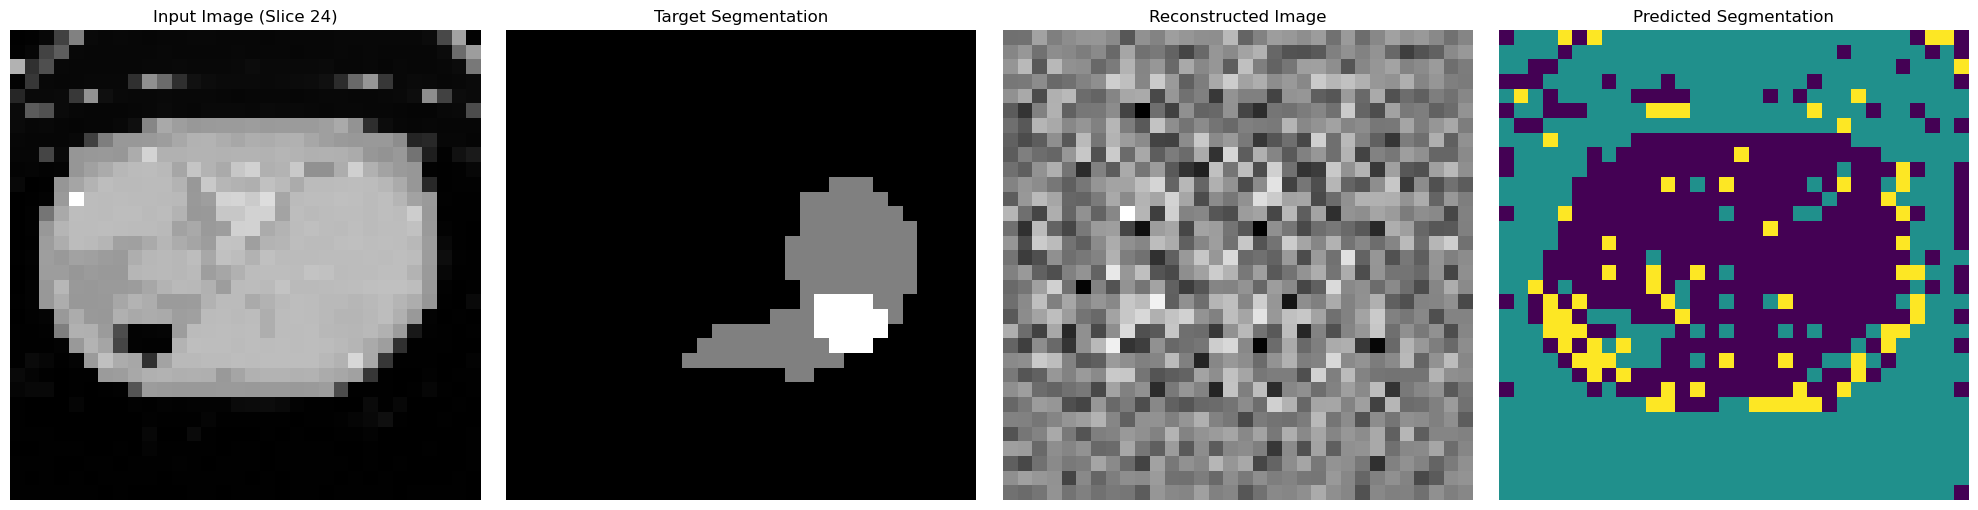

KeyboardInterrupt: 

In [16]:
if __name__ == "__main__":
    # start model
    model = MultiTaskNet(
        in_channels=1, 
        num_classes=NUM_CLASSES, 
        latent_dim=LATENT_DIM  
    ).to(device)

    # define loss and optimizer
    loss_fn_seg_dice = DiceLoss(num_classes= NUM_CLASSES)
    loss_fn_seg_cross = nn.CrossEntropyLoss()
    loss_fn_recon = nn.MSELoss()
    optimizer_model = optim.Adam(model.parameters(), lr=1e-3)

    print("--- Training the MultiTaskNet on Liver Data ---")
    NUM_EPOCHS = 31

    for epoch in range(NUM_EPOCHS):
        print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
        
        model.train() 
        
        # iterate over both loaders
        for batch_idx, ((x_labeled, y_seg_target), (x_unlabeled)) in \
                enumerate(zip(labeled_loader, itertools.cycle(unlabeled_loader))):
            
            # Move all data to device
            x_labeled = x_labeled.to(device)
            y_seg_target = y_seg_target
            x_unlabeled = x_unlabeled
            x_unlabeled = x_unlabeled[0]

            optimizer_model.zero_grad()
            
            # forward pass on labeled data for both seg and recon
            seg_out, recon_out_labeled, _ = model(x_labeled)
            
            # segmentation losses
            loss_seg_cross = loss_fn_seg_cross(seg_out, y_seg_target)
            
            total_loss_seg = loss_seg_cross * 1.0
            loss_seg_dice = 0.0
            
            # add dice loss if cross entropy is low enough
            if loss_seg_cross.item() < 0.6:
                dice_loss_component = loss_fn_seg_dice(seg_out, y_seg_target)
                total_loss_seg = total_loss_seg + (dice_loss_component * 1)
                loss_seg_dice = dice_loss_component.item()
                
            # labeled recon loss
            loss_recon_labeled = loss_fn_recon(recon_out_labeled, x_labeled)
                
            # Forward pass only on unlabeled data for recon
            _ , recon_out_unlabeled, _ = model(x_unlabeled)
            
            # unlabeled recon loss
            loss_recon_unlabeled = loss_fn_recon(recon_out_unlabeled, x_unlabeled)
            
            # Total recon loss
            total_loss_recon = loss_recon_labeled + loss_recon_unlabeled
            
            # Total combined loss
            total_loss = total_loss_seg + (total_loss_recon * 0.5) 
                
            total_loss.backward()
            optimizer_model.step()
            
            # Udate Logging
            if batch_idx % 30 == 0:
                if loss_seg_cross.item() > 0.6:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} (Dice not active)")
                else:
                    print(f"Batch {batch_idx}/{len(labeled_loader)} | Total Loss: {total_loss.item():.4f} | Recon Loss (Total): {total_loss_recon.item():.4f} | CE Loss (Labeled): {loss_seg_cross.item():.4f} | DICE Loss (Labeled): {loss_seg_dice:.4f}")
            
            # visualization update
            if epoch % 10 == 0 and batch_idx % 30 == 0:
                print("--- Visualizing first training batch (Labeled Data) ---")
                visualize_slices(x_labeled, y_seg_target, recon_out_labeled, seg_out)


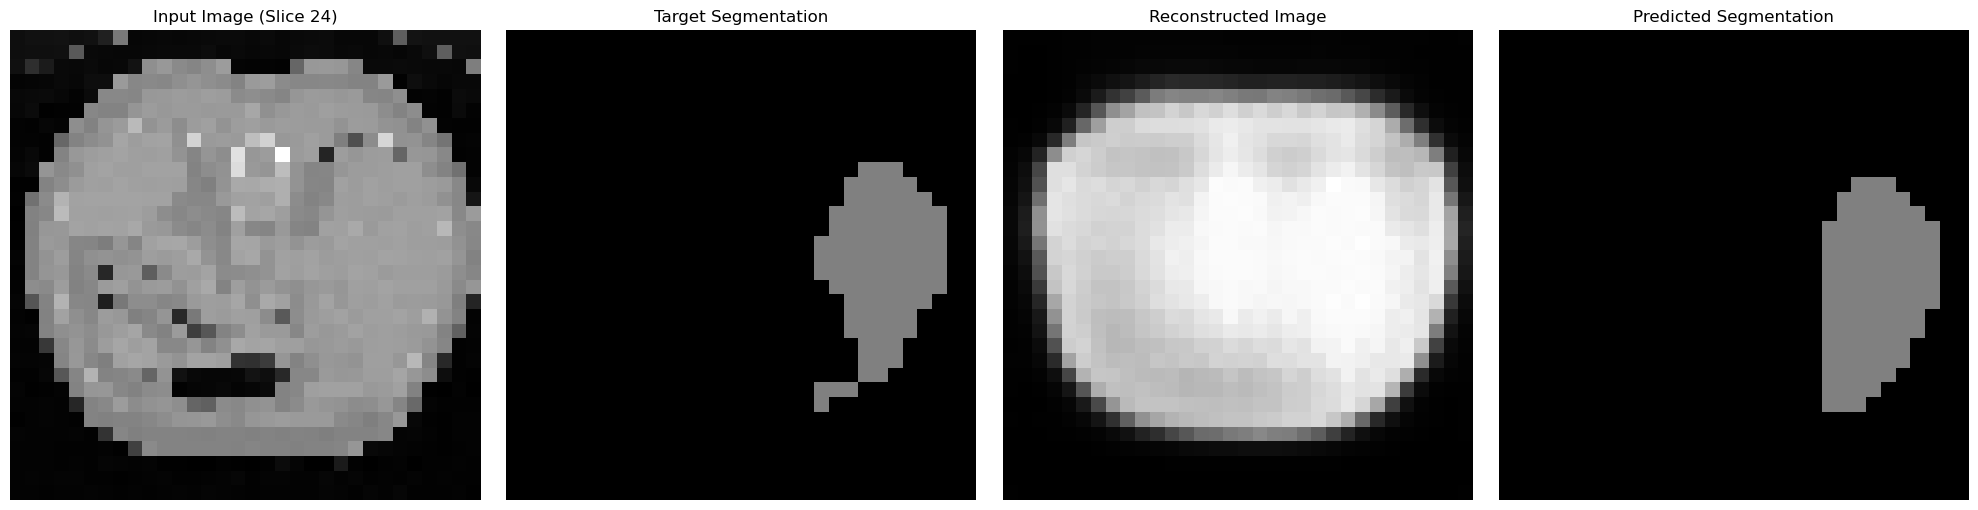

In [ ]:
visualize_slices(x_labeled, y_seg_target, recon_out, seg_out)


## The overfitting problem
The model is clearly overfitting because of the capacity of the model and the sparse data. The model is "focusing" its energy on learning the segmentation instead of learning both reconstruction and segmentation
$

Model to try -> self-supervised model, train then -> switch decoder head -> do semi-supervised learning, on the letant variable z.??

Transformer encoder, semi-super (mby self-supervised) -> normal cnn decoder, two head to handle segmentatoin and reconstruction and a transformer to handle temporal dimension


Why this method -> why is the transformer good for temporal, what does the litterature say?